In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
plt.style.use('ggplot')
#pd.set_option('max_rows',200) 
pd.set_option('display.float_format', '{:.4f}'.format) # Set decimals 


# Plot choices
sns.set(style="whitegrid")

(11549, 47)


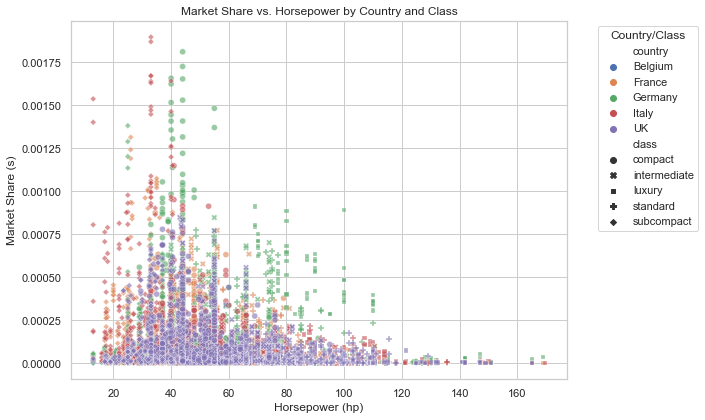

In [2]:
# Import data
cars = pd.read_csv('cars.csv')

print(cars.shape)

cars['hp'] = cars['hp'].str.replace(',', '.').astype(float)
cars['li'] = cars['li'].str.replace(',', '.').astype(float)
cars['li1'] = cars['li1'].str.replace(',', '.').astype(float)
cars['li2'] = cars['li2'].str.replace(',', '.').astype(float)
cars['li3'] = cars['li3'].str.replace(',', '.').astype(float)
cars['ngdp'] = cars['ngdp'].str.replace(',', '.').astype(float) # National GDP
cars['rgdp'] = cars['rgdp'].str.replace(',', '.').astype(float) #Regional GDP
cars['princ'] = cars['princ'].str.replace(',', '.').astype(float) #Price/Income - pris med inflation
cars['pr'] = cars['pr'].str.replace(',', '.').astype(float)
cars['tax'] = cars['tax'].str.replace(',', '.').astype(float)
cars['avdexr'] = cars['avdexr'].str.replace(',', '.').astype(float)
cars['ac'] = cars['ac'].str.replace(',', '.').astype(float) #acceleration
cars['le'] = cars['le'].str.replace(',', '.').astype(float) #length
cars['sp'] = cars['sp'].str.replace(',', '.').astype(float) #speed
#cars['we'] = cars['we'].str.replace(',', '.').astype(float) #weight


labs = pd.read_csv('labels_values.csv')
dict_varnames = pd.read_csv('labels_variables.csv').set_index('variable').to_dict()['label']

# to translate market indices to names of countries 
labs.index += 1 
dict_ma = labs.market.dropna().to_dict()



#'qu_total': Total sales, 'qu,' for each market, 'ma' and year, 'ye'.
cars['qu_total'] = cars.groupby(['ma','ye'])['qu'].transform('sum')
cars['qu_total'] = cars['qu'].sum()

#'s': Market share is the relation between'qu' and 'qu_total'
#Quantity of goods/the total quantity
cars['s'] = cars['qu'] / (cars['qu_total'])

cars['log_s'] = np.log(cars['s']) #måske /(0.5)

cars['country'] = cars['ma'].map(dict_ma)

dict_cla = labs.classs.dropna().to_dict()
cars['class'] = cars['cla'].map(dict_cla)


# Set the figure size for the scatterplot
plt.figure(figsize=(10, 6))

sns.scatterplot(data=cars, x='hp', y='s', hue='country', style='class', alpha=0.6)

# Set the title of the plot
plt.title('Market Share vs. Horsepower by Country and Class')

# Set the label for the x-axis
plt.xlabel('Horsepower (hp)')

# Set the label for the y-axis
plt.ylabel('Market Share (s)')

# Place a legend on the plot. 'bbox_to_anchor' and 'loc' help position the legend outside the plot area.
plt.legend(title='Country/Class', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()


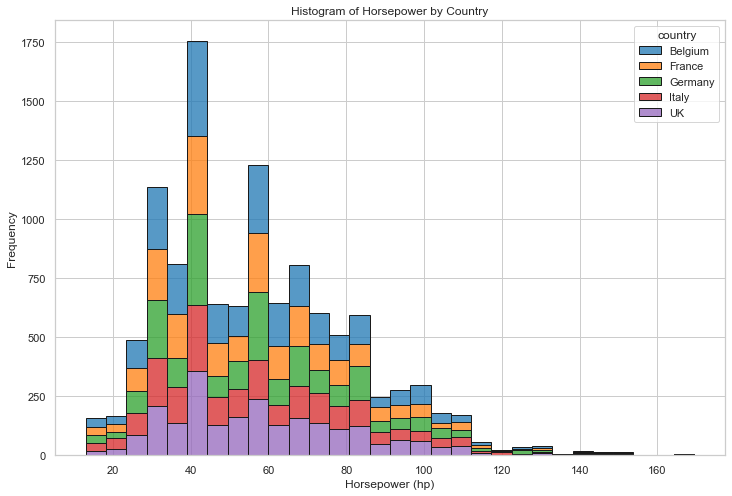

In [3]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create a combined histogram with the 'hue' parameter to differentiate by country
sns.histplot(data=cars, x='hp', hue='country', multiple='stack', bins=30, palette='tab10', edgecolor='k')

# Set titles and labels
plt.title('Histogram of Horsepower by Country')
plt.xlabel('Horsepower (hp)')
plt.ylabel('Frequency')

# Show the plot
plt.show()


- Fordeling af horsepower i hvert land, 
- Alle biler folk ejer, mere retvisende billede
- Market_shares for horsepowers så man kan se det
- princs, we, le, ...
- Summe market_shares indenfor hvert interval

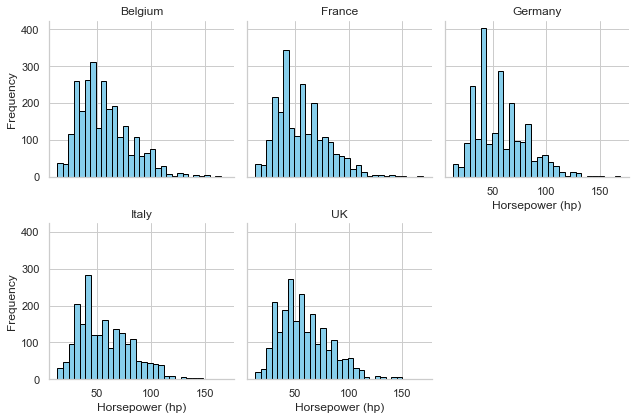

In [4]:
# Set up the FacetGrid with seaborn
g = sns.FacetGrid(cars, col='country', col_wrap=3, sharex=True, sharey=True)

# Map the histograms to the FacetGrid
g.map(plt.hist, 'hp', bins=30, color='skyblue', edgecolor='black')

# Add titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Horsepower (hp)', 'Frequency')

# Adjust the layout so that titles and labels don't overlap
g.tight_layout()

# Show the plot
plt.show()


# Average market share for each horsepower category per country

<Figure size 1008x504 with 0 Axes>

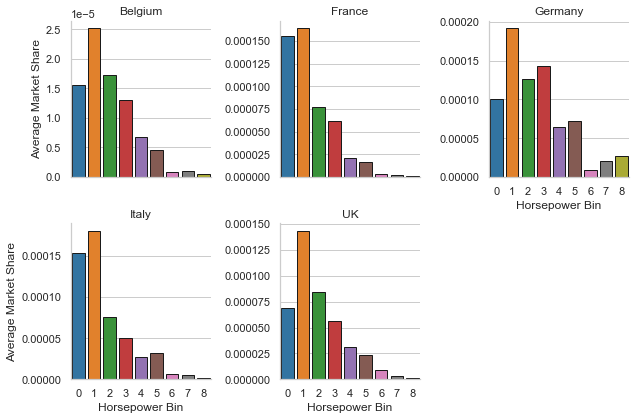

In [5]:
# Define the number of bins for horsepower
bins = np.linspace(cars['hp'].min(), cars['hp'].max(), num=10)

# Assign each car to a horsepower bin
cars['hp_bin'] = pd.cut(cars['hp'], bins, labels=np.arange(len(bins)-1))

# Group by country and horsepower bin, then calculate the average market share
avg_market_share = cars.groupby(['country', 'hp_bin'])['s'].mean().reset_index()

# Now plot the average market share for each country and horsepower bin as a bar plot
plt.figure(figsize=(14, 7))

# Because there are multiple countries and horsepower bins, we may choose to facet by country
# to make the plot clearer
g = sns.FacetGrid(avg_market_share, col='country', col_wrap=3, sharey=False)
g.map_dataframe(sns.barplot, x='hp_bin', y='s', palette='tab10', edgecolor='k')
g.set_axis_labels('Horsepower Bin', 'Average Market Share')
g.set_titles(col_template='{col_name}')

plt.show()


Forholde sig mere til figurerne:
- Tyskland kører på flest hestekrafter, mens frankrig og italien kører på dem med lavest. 

# Step 1: Creating a Histogram for Horsepower Distribution

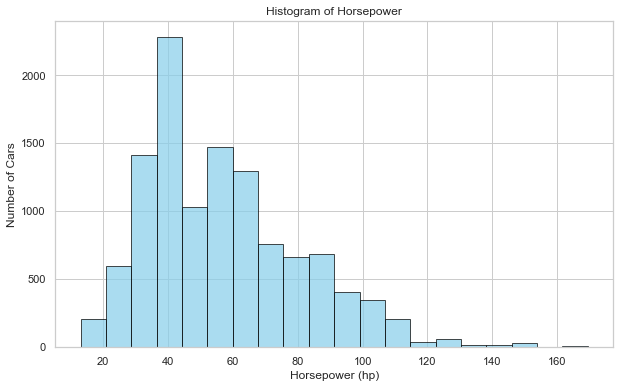

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(cars['hp'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Horsepower')
plt.xlabel('Horsepower (hp)')
plt.ylabel('Number of Cars')
plt.show()

Lave figur note her
- Hvad ser vi på figuren
    - Number of cars?
    - Forklare hvordan det er lavet
    - Aggregere forskellige models for horsepower
    - Selvfoklarende tabel
    - Færre bins (bins=20)

# Step 2: Creating a Binned Scatter Plot for Average Horsepower


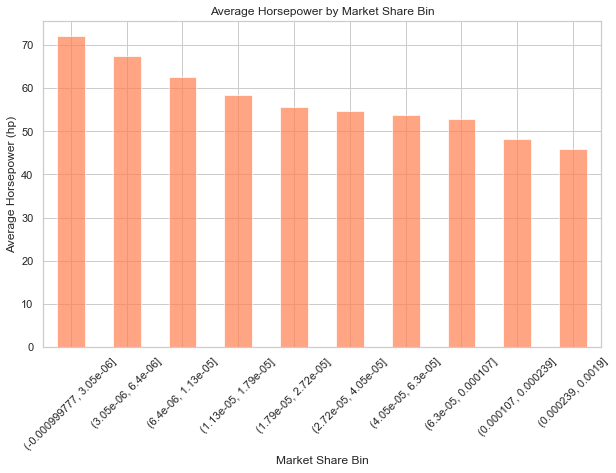

In [7]:
# Bin the market share data
cars['market_share_bin'] = pd.qcut(cars['s'], q=10, duplicates='drop')  # Creating 10 quantile-based bins

# Calculate the average horsepower for each bin
avg_hp_per_bin = cars.groupby('market_share_bin')['hp'].mean()

# Plotting
plt.figure(figsize=(10, 6))
avg_hp_per_bin.plot(kind='bar', color='coral', alpha=0.7)
plt.title('Average Horsepower by Market Share Bin')
plt.xlabel('Market Share Bin')
plt.ylabel('Average Horsepower (hp)')
plt.xticks(rotation=45)
plt.show()


- Summe her også
- Binn scatter
    - x og y, laver bins, gennemsnittet for hvert bin
    - Summe marketshares på x aksen og horsepower på yaksen

# Calculating Average Horsepower by Year


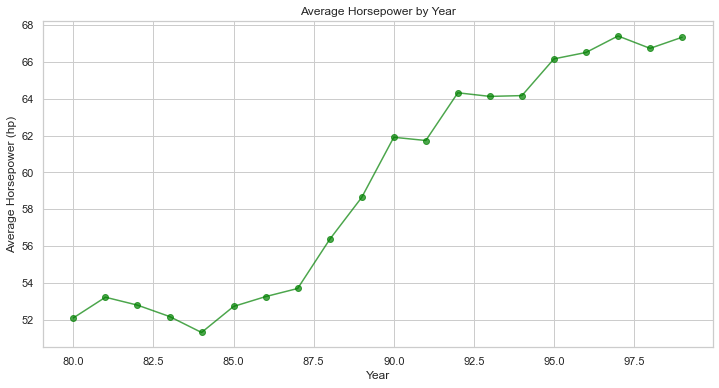

In [8]:
# Filtrer data til kun at inkludere år fra 1980 til 2000
filtered_cars = cars[(cars['ye'] >= 80) & (cars['ye'] <= 100)]

# Grupper efter år og beregn gennemsnitlig hestekraft
avg_hp_per_year = filtered_cars.groupby('ye')['hp'].mean()

# Plotting af gennemsnitlig hestekraft over årene
plt.figure(figsize=(12, 6))
avg_hp_per_year.plot(kind='line', marker='o', color='green', alpha=0.7)
plt.title('Average Horsepower by Year')
plt.xlabel('Year')
plt.ylabel('Average Horsepower (hp)')
plt.grid(True)
plt.show()


- Average over forskellige alle brands
- Lave et vægtet gennemsnit så det er for lamboginier og toyotaer for sig kan man sige
- Alt vægtes med marketshares
- Manuelt regne ud evt. 

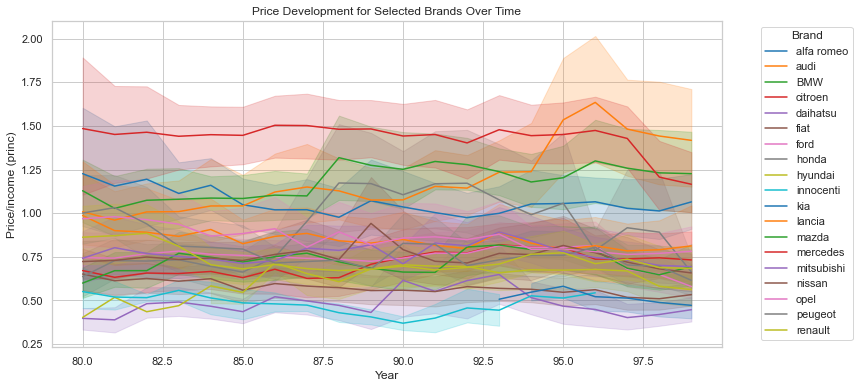

In [9]:
# Correctly handle infinite and missing values before any manipulation
cars.replace([np.inf, -np.inf], np.nan, inplace=True)

# Filter the dataset for selected brands and the year range 1980 to 2000
selected_brands = cars[
    (cars['brand'].isin(['alfa romeo', 'audi', 'BMW', 'citroen', 'daihatsu', 'fiat', 
                         'ford', 'honda', 'hyundai', 'innocenti', 'kia', 'lancia', 'mazda', 'mercedes',
                         'mitsubishi', 'nissan', 'opel', 'peugeot', 'renault'])) & 
    (cars['ye'] >= 80) & (cars['ye'] <= 100)
]

# Create a line plot showing the development of prices over years for the selected brands
plt.figure(figsize=(12, 6))
sns.lineplot(data=selected_brands, x='ye', y='princ', hue='brand', palette='tab10')  # Adjusted for a better color palette
plt.title('Price Development for Selected Brands Over Time')
plt.xlabel('Year')
plt.ylabel('Price/income (princ)')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

# Show the plot
plt.show()


- Kigge på mercedes - måske fjerne for den ene obs.
- Se om der er taget gennemsnit - mere præcis 
- sns - rigtige library?
- Begrunde spiken - evt. noget valuta - 

- BMW har stor (95% af markedet) og lille (5%)
    - Den store har højere price income ratio
        - Og price
    - De tæller ikke lige meget
    - Tage 5% gange price/income lille + 95%*price/income stor
    - Skaber en market share rate
    - (Vægtet gennemsnit)
- Være mere selektiv hvis det er
    - For 5-10 største brands
        - Mindre støj
- Price/income og price ratio
    - Graf for hver

# Plotting Price Development for All Brands Over Time

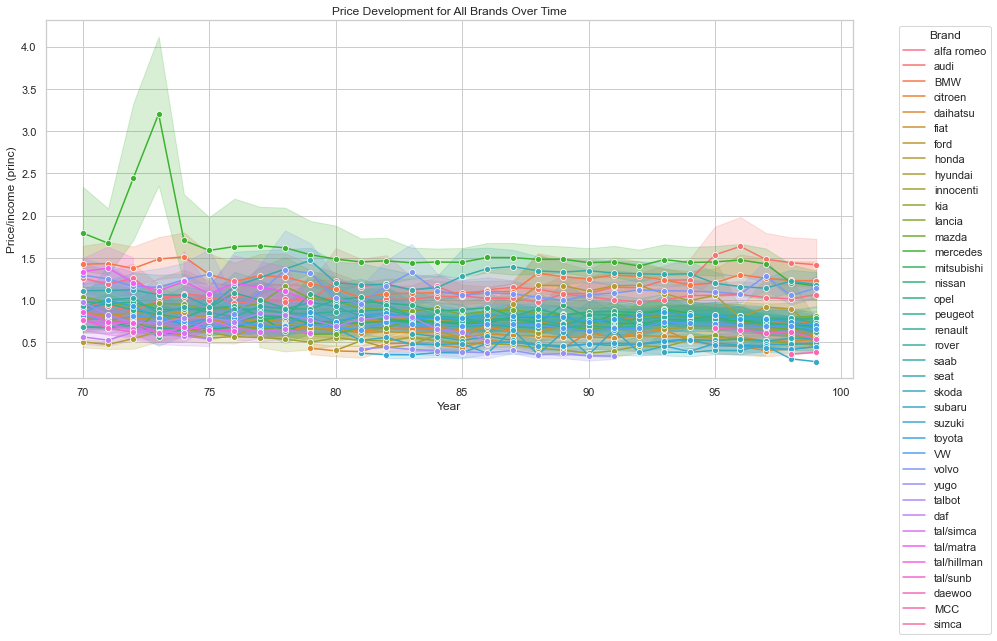

In [10]:
# Create a line plot showing the development of prices over years for all brands
# Filter the dataset for the year range 1980 to 2000 for all brands
filtered_cars_all_brands = cars[(cars['ye'] >= 80) & (cars['ye'] <= 100)]
plt.figure(figsize=(14, 8))
sns.lineplot(data=cars, x='ye', y='princ', hue='brand', marker='o', legend='full')
plt.title('Price Development for All Brands Over Time')
plt.xlabel('Year')
plt.ylabel('Price/income (princ)')
plt.legend(title='Brand', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()


- lave nogle grafer for at se hvad der er i variablerne - variable over tid
- Giver det mening at tage pris/indkomst (lokal valuta) på tværs af lande (med inflation) - læse verbovens paper mm. for hvilke mål
- Enheden i prices
- Faste og løbende priser - inflation => rene priser= fjerne inflation samt
- Giver det mening med priser for brands

# Using regplot for a Single Scatterplot with Regression Line


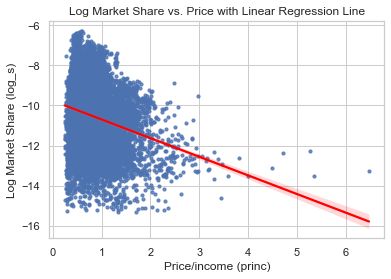

In [11]:
# Use seaborn's regplot to create a scatterplot of 'pr' vs. 'log_s'.
# 'x' specifies the data for the x-axis (Price in this case).
# 'y' specifies the data for the y-axis (Log Market Share in this case).

sns.regplot(x='princ', y='log_s', data=cars, scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Set the title of the plot with plt.title.
plt.title('Log Market Share vs. Price with Linear Regression Line')

# Set the label for the x-axis with plt.xlabel.
plt.xlabel('Price/income (princ)')

# Set the label for the y-axis with plt.ylabel.
plt.ylabel('Log Market Share (log_s)')

# Display the plot with plt.show().
plt.show()


# Integrate this into the regression setup - Only with prices

In [12]:
# Replace 'pr', 'hp' etc., with the actual attribute names you want to include
cars['princ'] = pd.to_numeric(cars['princ'], errors='coerce')
# Convert additional attributes as needed

# Replace any infinite values with NaN and then drop rows with NaN values in these columns
cars.replace([np.inf, -np.inf], np.nan, inplace=True)
cars.dropna(subset=['princ'], inplace=True)  # Include all your predictor columns in the subset list

# Prepare your independent variables DataFrame including the constant and other variables
X = cars[['princ']]  # I can add more attributes if it is needed
X = sm.add_constant(X)

# Define your dependent variable
y = cars['log_s']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of your regression model
print(model.summary())

print(cars.shape)


                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     669.6
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          1.45e-143
Time:                        20:49:31   Log-Likelihood:                -21681.
No. Observations:               11549   AIC:                         4.337e+04
Df Residuals:                   11547   BIC:                         4.338e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7708      0.033   -294.884      0.0

# Integrate this into the regression setup

In [13]:
# Convert all predictor variables to numeric type and handle missing/infinite values
cars['pr'] = pd.to_numeric(cars['pr'], errors='coerce')
cars['hp'] = pd.to_numeric(cars['hp'], errors='coerce')
cars['ac'] = pd.to_numeric(cars['ac'], errors='coerce')

# Replace any infinite values with NaN and then drop rows with NaN values in these columns
cars.replace([np.inf, -np.inf], np.nan, inplace=True)
cars.dropna(subset=['pr', 'hp', 'ac'], inplace=True)  # Include all the predictor columns in the subset list

# Preparing the independent variables DataFrame including the constant and other variables
X = cars[['pr', 'hp', 'ac']]  # I can add more attributes if it is needed
X = sm.add_constant(X)

# Defining the dependent (afhængige) variable
y = cars['log_s']

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the summary of your regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     433.8
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          1.24e-263
Time:                        20:49:31   Log-Likelihood:                -17092.
No. Observations:                9232   AIC:                         3.419e+04
Df Residuals:                    9228   BIC:                         3.422e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5594      0.111    -77.088      0.0

In [14]:
# Liste over attributter
attributes = ['princ', 'we', 'ac', 'hp', 'le']  # Erstat med dine attributter

# Regression kun med pris
X_price = sm.add_constant(cars[['princ']])  # Antag at 'princ' er prisen
model_price = sm.OLS(cars['log_s'], X_price).fit()
print(model_price.summary())

# Loop gennem hver attribut og kør regression med pris og den pågældende attribut
for attr in attributes:
    X_attr = sm.add_constant(cars[['princ', 'we', 'ac', 'hp', 'le']])  # Tilføj attributten til modellen
    model_attr = sm.OLS(cars['log_s'], X_attr).fit()
    print(f"Regression med pris og {attr}:")
    print(model_attr.summary())
    print("\n")
    

                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     579.0
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          3.96e-124
Time:                        20:49:31   Log-Likelihood:                -17421.
No. Observations:                9232   AIC:                         3.485e+04
Df Residuals:                    9230   BIC:                         3.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.6165      0.037   -257.449      0.0

- Køre regressionerne country by country => se om princ ryger på minus
- Det er horsepower som påvirker princ - den går fra negativ til positiv, hvilket ikke burde være rigtigt
- Lave om på estimater

# Forklarende variabler og model-dummies i OLS-regression

In [15]:
# Tjekker for at sikre, at 'brand' kolonnen eksisterer
print(cars.columns)

# Hvis 'brand' eksisterer, opretter vi dummy-variabler
if 'brand' in cars.columns:
    cars = pd.get_dummies(cars, columns=['brand'], drop_first=True)
else:
    print("'brand' kolonnen findes ikke i DataFrame.")


Index(['ye', 'ma', 'co', 'zcode', 'brd', 'type', 'brand', 'model', 'org',
       'loc', 'cla', 'home', 'frm', 'qu', 'cy', 'hp', 'we', 'pl', 'do', 'le',
       'wi', 'he', 'li1', 'li2', 'li3', 'li', 'sp', 'ac', 'pr', 'princ',
       'eurpr', 'exppr', 'avexr', 'avdexr', 'avcpr', 'avppr', 'avdcpr',
       'avdppr', 'xexr', 'tax', 'pop', 'ngdp', 'rgdp', 'engdp', 'ergdp',
       'engdpc', 'ergdpc', 'qu_total', 's', 'log_s', 'country', 'class',
       'hp_bin', 'market_share_bin'],
      dtype='object')


In [16]:
# Antag at 'pr' er prisen, og 'hp' er hestekræfter
X = cars[['princ', 'hp']]  # Starter med prisen og hestekræfter
X = pd.concat([X, cars.filter(regex='brand_')], axis=1)  # Tilføjer brand-dummy-variablerne
X = sm.add_constant(X)  # Tilføjer en konstant til modellen - estimere den basale værdi af den afhængige variabel, når alle de uafhængige variabler er nul. 
#Det forbedrer modeltilpasningen og sikrer mere nøjagtige og realistiske estimater.

y = cars['log_s']  # Logaritmiske markedsandel

# Kører OLS-modellen
model = sm.OLS(y, X).fit()

# Viser summary af modellen
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  log_s   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     97.09
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:49:32   Log-Likelihood:                -16144.
No. Observations:                9232   AIC:                         3.237e+04
Df Residuals:                    9193   BIC:                         3.264e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -8.1395      0.09

# IV-regression

## Beregne summen af hp for hver biltype, hvert år, og hvert land

In [17]:
# Gruppere data efter 'type', 'ye', og 'country' og beregne summen af 'hp' for hver gruppe
hp_sum = cars.groupby(['type', 'ye', 'country'])['hp'].sum().reset_index(name='hp_sum')

# Viser de første par rækker af det aggregerede dataset for at tjekke
print(hp_sum.head())


                      type  ye  country  hp_sum
0  BMW 1500-1600-1602-1802  72  Belgium 62.5000
1  BMW 1500-1600-1602-1802  72   France 62.5000
2  BMW 1500-1600-1602-1802  72  Germany 62.5000
3  BMW 1500-1600-1602-1802  72    Italy 70.5000
4  BMW 1500-1600-1602-1802  72       UK 62.5000


## Implementering af første trin i IV-estimeringen:

In [18]:
cars['s'].sum()

0.889113166987858

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

# Log_s mod s and p => herfra estimere med IV, herunder have instrumenter (BLP beskriver summen)
# summen af attributes 

hp_sum = cars.groupby(['type', 'ye', 'country'])['hp'].sum().reset_index(name='hp_sum')

#Tilføjer hp_sum som kolonne 
cars_IV = pd.merge(cars, hp_sum, on=['type', 'ye', 'country'])

# 'tax' er vores instrument, og vi definerer det som 'z' i datasættet
cars_IV['z'] = cars_IV['hp_sum']  # Opdatering af 'z' til at være 'hp_sum'

#Kigge på de to pakker

# Implementation af: p = \gamma*x1 + \phi*z + v, som er ('princ ~ x1 + z') => Første trins regression med 'z' som instrument for 'princ' 
first_stage = smf.ols('princ ~ hp + ac + we + le + z', data=cars_IV).fit(cov_type='HC3')
#Princ = eneste afhængige variable, alle de andre er uafhængige

# Tilføj de forudsagte værdier fra første trin til din DataFrame
cars_IV['princ_fitted'] = first_stage.fittedvalues
# princ_fittet => forudsagte værdier

# Vi har kun en 'Intercept' kolonne
if 'Intercept' not in cars_IV.columns:
    cars_IV['Intercept'] = 1.0
    
    
second_stage = IV2SLS(dependent=cars_IV['log_s'],  # Den afhængige variabel
                      exog=cars_IV[['Intercept', 'ac', 'we', 'le']],  # Eksogene variabler
                      endog=cars_IV['princ_fitted'],  # Den oprindeligt endogene variabel
                      instruments=cars_IV['z']).fit()  # 'z' er instrumentet
# Her defineres ln(q) = \beta*x1 + \alpha*p + \epsilon


# Udskriv resultaterne

print(first_stage.summary())


print(second_stage.summary)

second_stageOLS = smf.ols('log_s ~ hp + ac + we + le + princ', data=cars_IV).fit(cov_type='HC3')

print(second_stageOLS.summary("second_stage_OLS"))

                            OLS Regression Results                            
Dep. Variable:                  princ   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     2579.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:49:32   Log-Likelihood:                -324.77
No. Observations:                9232   AIC:                             659.5
Df Residuals:                    9227   BIC:                             695.2
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8830      0.033    -26.643      0.0

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '


## Instrument for 'ac'

### Beregne summen af hp for hver biltype, hvert år, og hvert land

In [20]:
# Gruppere data efter 'type', 'ye', og 'country' og beregne summen af 'hp' for hver gruppe
ac_sum = cars.groupby(['type', 'ye', 'country'])['ac'].sum().reset_index(name='ac_sum')

# Viser de første par rækker af det aggregerede dataset for at tjekke
print(ac_sum.head())


                      type  ye  country  ac_sum
0  BMW 1500-1600-1602-1802  72  Belgium 13.3000
1  BMW 1500-1600-1602-1802  72   France 13.3000
2  BMW 1500-1600-1602-1802  72  Germany 13.3000
3  BMW 1500-1600-1602-1802  72    Italy 13.3000
4  BMW 1500-1600-1602-1802  72       UK 13.3000


In [21]:
ac_sum = cars.groupby(['type', 'ye', 'country'])['ac'].sum().reset_index(name='ac_sum')

#Tilføjer hp_sum som kolonne 
cars_IV = pd.merge(cars, ac_sum, on=['type', 'ye', 'country'])

# 'tax' er vores instrument, og vi definerer det som 'z' i datasættet
cars_IV['w'] = cars_IV['ac_sum']  # Opdatering af 'z' til at være 'hp_sum'

#Kigge på de to pakker

# Implementation af: p = \gamma*x1 + \phi*z + v, som er ('princ ~ x1 + z') => Første trins regression med 'z' som instrument for 'princ' 
first_stage_ac = smf.ols('princ ~ hp + ac + we + le + w', data=cars_IV).fit(cov_type='HC3')
#Princ = eneste afhængige variable, alle de andre er uafhængige

# Tilføj de forudsagte værdier fra første trin til din DataFrame
cars_IV['princ_fitted_ac'] = first_stage_ac.fittedvalues 
# princ_fittet => forudsagte værdier

# Vi har kun en 'Intercept' kolonne
if 'Intercept' not in cars_IV.columns:
    cars_IV['Intercept'] = 1.0
    
    
second_stage_ac = IV2SLS(dependent=cars_IV['log_s'],
                      exog=cars_IV[['Intercept', 'hp', 'we', 'le']],
                      endog=cars_IV['princ_fitted_ac'],  # Brug den forudsagte 'ac'
                      instruments=cars_IV['w']).fit()
# Her defineres ln(q) = \beta*x1 + \alpha*p + \epsilon


# Udskriv resultaterne

print(second_stage_ac.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  log_s   R-squared:                      0.1500
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1497
No. Observations:                9232   F-statistic:                    1771.6
Date:                Sun, Mar 24 2024   P-value (F-stat)                0.0000
Time:                        20:49:33   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept          -12.295     0.2679    -45.901     0.0000     -12.820     -11.770
hp                 -0.0327     0

## Instrument for 'we'

In [22]:
# Gruppere data efter 'type', 'ye', og 'country' og beregne summen af 'hp' for hver gruppe
we_sum = cars.groupby(['type', 'ye', 'country'])['we'].sum().reset_index(name='we_sum')

# Viser de første par rækker af det aggregerede dataset for at tjekke
print(we_sum.head())


                      type  ye  country  we_sum
0  BMW 1500-1600-1602-1802  72  Belgium     930
1  BMW 1500-1600-1602-1802  72   France     930
2  BMW 1500-1600-1602-1802  72  Germany     930
3  BMW 1500-1600-1602-1802  72    Italy     930
4  BMW 1500-1600-1602-1802  72       UK     930


In [23]:
we_sum = cars.groupby(['type', 'ye', 'country'])['we'].sum().reset_index(name='we_sum')

#Tilføjer hp_sum som kolonne 
cars_IV = pd.merge(cars, we_sum, on=['type', 'ye', 'country'])

# 'tax' er vores instrument, og vi definerer det som 'z' i datasættet
cars_IV['x'] = cars_IV['we_sum']  # Opdatering af 'z' til at være 'hp_sum'

# Implementation af: p = \gamma*x1 + \phi*z + v, som er ('princ ~ x1 + z') => Første trins regression med 'z' som instrument for 'princ' 
first_stage_we = smf.ols('princ ~ hp + ac + we + le + x', data=cars_IV).fit(cov_type='HC3')
#Princ = eneste afhængige variable, alle de andre er uafhængige

# Tilføj de forudsagte værdier fra første trin til din DataFrame
cars_IV['princ_fitted_we'] = first_stage_we.fittedvalues 
# princ_fittet => forudsagte værdier

# Vi har kun en 'Intercept' kolonne
if 'Intercept' not in cars_IV.columns:
    cars_IV['Intercept'] = 1.0
    
    
second_stage_we = IV2SLS(dependent=cars_IV['log_s'],
                          exog=cars_IV[['Intercept', 'hp', 'ac', 'le']], 
                          endog=cars_IV['princ_fitted_we'],
                          instruments=cars_IV['x']).fit()  # Her anvender vi 'x' som instrument for 'princ'
# Her defineres ln(q) = \beta*x1 + \alpha*p + \epsilon

print(second_stage_we.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  log_s   R-squared:                      0.1500
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1497
No. Observations:                9232   F-statistic:                    1771.6
Date:                Sun, Mar 24 2024   P-value (F-stat)                0.0000
Time:                        20:49:33   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           53.335     7.3551     7.2514     0.0000      38.919      67.750
hp                 -0.9715     0

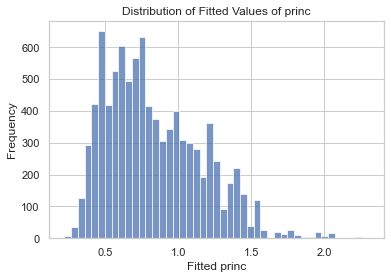

Summary stats for 'princ_fitted_we':
count   9232.0000
mean       0.8337
std        0.3298
min        0.2195
25%        0.5727
50%        0.7652
75%        1.0600
max        2.3047
Name: princ_fitted_we, dtype: float64
Summary stats for original 'princ':
count   9232.0000
mean       0.8337
std        0.4143
min        0.2418
25%        0.5405
50%        0.7386
75%        1.0189
max        6.4729
Name: princ, dtype: float64


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

cars_IV['princ_fitted_we'] = first_stage_we.fittedvalues 

# Tjekker forudsagte værdier af 'princ'
sns.histplot(cars_IV['princ_fitted_we'])
plt.title('Distribution of Fitted Values of princ')
plt.xlabel('Fitted princ')
plt.ylabel('Frequency')
plt.show()

# Tjekker, om der er nogen outliers i forudsagte værdier
print("Summary stats for 'princ_fitted_we':")
print(cars_IV['princ_fitted_we'].describe())

# Tjekker, om der er nogen outliers i den oprindelige 'princ' variabel
print("Summary stats for original 'princ':")
print(cars['princ'].describe())


## Instrument for 'le'

In [25]:
# Gruppere data efter 'type', 'ye', og 'country' og beregne summen af 'hp' for hver gruppe
le_sum = cars.groupby(['type', 'ye', 'country'])['le'].sum().reset_index(name='le_sum')

# Viser de første par rækker af det aggregerede dataset for at tjekke
print(le_sum.head())


                      type  ye  country   le_sum
0  BMW 1500-1600-1602-1802  72  Belgium 423.0000
1  BMW 1500-1600-1602-1802  72   France 423.0000
2  BMW 1500-1600-1602-1802  72  Germany 423.0000
3  BMW 1500-1600-1602-1802  72    Italy 423.0000
4  BMW 1500-1600-1602-1802  72       UK 423.0000


In [26]:
le_sum = cars.groupby(['type', 'ye', 'country'])['le'].sum().reset_index(name='le_sum')

#Tilføjer hp_sum som kolonne 
cars_IV = pd.merge(cars, le_sum, on=['type', 'ye', 'country'])

# 'tax' er vores instrument, og vi definerer det som 'z' i datasættet
cars_IV['y'] = cars_IV['le_sum']  # Opdatering af 'z' til at være 'hp_sum'

#Kigge på de to pakker

# Implementation af: p = \gamma*x1 + \phi*z + v, som er ('princ ~ x1 + z') => Første trins regression med 'z' som instrument for 'princ' 
first_stage_le = smf.ols('princ ~ hp + ac + we + le + y', data=cars_IV).fit(cov_type='HC3')
#Princ = eneste afhængige variable, alle de andre er uafhængige

# Tilføj de forudsagte værdier fra første trin til din DataFrame
cars_IV['princ_fitted_le'] = first_stage_le.fittedvalues  # 'princ_fitted' indeholder nu forudsagte værdier for 'princ'
# princ_fittet => forudsagte værdier

# Vi har kun en 'Intercept' kolonne
if 'Intercept' not in cars_IV.columns:
    cars_IV['Intercept'] = 1.0
    
    
second_stage_le = IV2SLS(dependent=cars_IV['log_s'],
                          exog=cars_IV[['Intercept', 'hp', 'ac', 'we']], 
                          endog=cars_IV['princ_fitted_le'],
                          instruments=cars_IV['y']).fit()  # Her anvender vi 'y' som instrument for 'princ'

# Her defineres ln(q) = \beta*x1 + \alpha*p + \epsilon


# Udskriv resultaterne

print(second_stage_le.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  log_s   R-squared:                      0.1500
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1497
No. Observations:                9232   F-statistic:                    1771.6
Date:                Sun, Mar 24 2024   P-value (F-stat)                0.0000
Time:                        20:49:33   Distribution:                  chi2(4)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept          -8.7779     0.2410    -36.424     0.0000     -9.2502     -8.3056
hp                 -0.0830     0

In [27]:
#print(cars_IV[['Intercept', 'hp', 'ac', 'we', 'le', 'z']].describe())

## Prøver med Bertels kode fra øvelsestimerne??

- lave 2 gange OLS for at genskabe resultat så man ved hvad der foregår
- BLP estimates (z) - gennemsnit osv. - læse dokumentation
- Beregn elasticitet af formlerne 
- Negative priselasticiteter
- Sidste kolonne for nye instrumenter

# Priselasticiteter


In [28]:
def utility_function(price, alpha, x, beta):
    """
    Dette er et eksempel på en nyttefunktion, hvor:
    - price er prisen på produktet
    - alpha er koefficienten for prisen
    - x er en anden attribut for produktet
    - beta er koefficienten for attributten x
    """
    return alpha * price + beta * x

def calculate_price_elasticity(price, alpha, P_ni, x=None, beta=None):
    """
    Beregner priselasticiteten for en given pris og markedsandel (P_ni).
    """
    # V_ni som alpha * price => hvis kun pris påvirker nytten direkte
    V_ni_derivative = alpha  # FOC - Den afledte af V_ni med hensyn til pris er beta_price
    z_ni = price  # Prisen for produktet
    
    # Beregn elasticiteten - formlen
    elasticity = V_ni_derivative * z_ni * (1 - P_ni)
    
    return elasticity

# Beregn en gennemsnitlig markedsandel for det samlede marked eller et segment
average_market_share = cars['s'].mean()

# Beregn en gennemsnitlig pris for det samlede marked eller et segment
average_price = cars['princ'].mean()

price = cars['princ']
P_ni = cars['s'] 

alpha = -0.9308 # Pris-koefficient fra OLS regressionen - må den være minus?

elasticity = calculate_price_elasticity(average_price, alpha, average_market_share)

print(f"Priselasticiteten for markedet/produktet er: {elasticity}")


Priselasticiteten for markedet/produktet er: -0.7759101993457133


* Hver 1% ændring i prisen, vil mængden af efterspurgt ændre sig med ca. 0.776% i den modsatte retning*
* Hvor følsom efterspørgslen efter et produkt eller en service er over for ændringer i prisen på dette produkt
* Relativt uelastiske, hvilket betyder, at efterspørgslen ikke er meget følsom over for prisændringer.*

## Priselasticitet for specifikt brand, år og land

In [29]:
# Filtrering baseret på 'brand_alfa romeo', 'ye' for år, og 'country' for land
specific_data = cars[(cars['brand_alfa romeo'] == 1) & (cars['ye'] == 83) & (cars['country'] == 'Belgien')]

# Tjek og print specifik data for at bekræfte
print("Specifik data for Alfa Romeo i Belgien, 1983:")
print(specific_data[['brand_alfa romeo', 'ye', 'country', 'princ']])

# Beregn gennemsnitsprisen for Alfa Romeo biler
# Her bruger vi 'brand_alfa romeo' == 1 til at filtrere alle Alfa Romeo biler
average_price_alfa_romeo = cars[cars['brand_alfa romeo'] == 1]['princ'].mean()
print(f"\nGennemsnitsprisen for Alfa Romeo biler er: {average_price_alfa_romeo:.2f}")

# Antager at 'alpha' er defineret (f.eks., alpha = -9.7708 som tidligere nævnt)
# Nu beregner vi priselasticiteten for Alfa Romeo biler
cars['price_elasticity_alfa_romeo'] = alpha * cars['princ'] / cars['s'] * (cars['brand_alfa romeo'] == 1)

# Vis resultatet for Alfa Romeo biler
alfa_romeo_elasticity = cars[cars['brand_alfa romeo'] == 1]
print("\nPriselasticiteten for Alfa Romeo biler:")
print(alfa_romeo_elasticity[['brand_alfa romeo', 'ye', 'country', 'princ', 'price_elasticity_alfa_romeo']])


Specifik data for Alfa Romeo i Belgien, 1983:
Empty DataFrame
Columns: [brand_alfa romeo, ye, country, princ]
Index: []

Gennemsnitsprisen for Alfa Romeo biler er: 0.98

Priselasticiteten for Alfa Romeo biler:
       brand_alfa romeo  ye  country  princ  price_elasticity_alfa_romeo
1                     1  84  Belgium 0.7620                  -87258.4590
2                     1  85  Belgium 0.7363                  -88548.0774
3                     1  86  Belgium 0.6591                  -68577.8660
4                     1  87  Belgium 0.6493                  -64413.9166
5                     1  88  Belgium 0.6525                  -66592.6208
...                 ...  ..      ...    ...                          ...
9308                  1  97       UK 1.1673                 -246156.5816
11254                 1  70       UK 1.3906                 -192448.7346
11506                 1  98       UK 1.2228                  -52170.0006
11507                 1  99       UK 1.1757                 

* Langt fra priselasticitet "-0.775", og viser meget store elasticiteter (negativt set), hvilket indikerer ekstrem følsomhed over for prisændringer, hvilket kan skyldes, hvordan markedsandelen og prisen for disse specifikke biler interagerer i din beregningsformel.

# Egenpriselasticitet

In [30]:
def calculate_own_price_elasticity(alpha, price, P_ni):
    """
    Beregner egenpriselasticiteten for et produkt.
    :param beta_price: Koefficienten for pris.
    :param price: Prisen på produktet.
    :param P_ni: Markedsandelen for produktet.
    :return: Egenpriselasticiteten.
    """
    own_price_elasticity = alpha * price * (1 - P_ni)
    return own_price_elasticity

# Antag, at alpha repræsenterer koefficienten for pris (princ) i din model
alpha = -0.9308   # Pris-koefficient fra OLS regressionen

price = cars['princ'] # Prisen på produktet
P_ni = cars['s'] #P_ni = s = Markedsandelen for produktet

own_price_elasticity = calculate_own_price_elasticity(alpha, price, P_ni)

print(f"Egenpriselasticiteten er: {own_price_elasticity}")


Egenpriselasticiteten er: 1       -0.7093
2       -0.6853
3       -0.6135
4       -0.6044
5       -0.6074
          ...  
11544   -1.3962
11545   -1.1128
11546   -0.4562
11547   -0.4773
11548   -0.8766
Length: 9232, dtype: float64


* Efterspørgslen efter et bestemt produkt ændrer sig som følge af en ændring i prisen på netop dette produkt, mens alle andre faktorer holdes konstante
* Efterspørgslen ændrer sig for hvor meget man ændrer prisen => Alle valutaer ikke i 

In [31]:
# Tjek for Alfa 33
#print("Types available:", cars['type'].unique())

# Tjek for Alfa Romeo biler
#print("Alfa Romeo Indicator Counts:", cars['brand_alfa romeo'].value_counts())

# Tjek for Belgium
print("Countries available:", cars['country'].unique())  


Countries available: ['Belgium' 'France' 'Germany' 'Italy' 'UK']


In [32]:
# Filtrer data
#alfa_33_belgium = cars[(cars['type'] == 'alfa 33') & (cars['brand_alfa romeo'] == 1) & (cars['country'] == 'Belgium')]

alfa_33_belgium = cars[
    (cars['type'] == 'alfa 33') & 
    (cars['brand_alfa romeo'] == 1) & 
    (cars['country'] == 'Belgium') & 
    (cars['ye'] >= 80) &  # Assuming 'ye' contains the year as the last two digits
    (cars['ye'] <= 100)
]


# Beregn gennemsnittet af 'princ' for Alfa 33 i Belgium
alpha_alfa_33 = alfa_33_belgium['princ'].mean()

# 's' kolonnen repræsenterer markedsandel
alfa_33_belgium['own_price_elasticity'] = alfa_33_belgium.apply(
    lambda row: calculate_own_price_elasticity(alpha_alfa_33, row['princ'], row['s']), axis=1)

# Beregn gennemsnittet af egenpriselasticiteten for Alfa 33 i Belgium
average_own_price_elasticity = alfa_33_belgium['own_price_elasticity'].mean()

# Vis resultatet
print(f"Gennemsnitlig egenpriselasticitet for alfa 33 i Belgien: {average_own_price_elasticity:.4f}")

# Hvis du vil vise de enkelte observationer kan du bruge:
#print(alfa_33_belgium[['type', 'brand_alfa romeo', 'country', 'own_price_elasticity']])


Gennemsnitlig egenpriselasticitet for alfa 33 i Belgien: 0.4252


/var/folders/fq/jrmcw87s5bvdvtl2jq535p1m0000gn/T/ipykernel_3788/4119986487.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alfa_33_belgium['own_price_elasticity'] = alfa_33_belgium.apply(


In [33]:
# Filtrer data for Alfa 33, brand Alfa Romeo, og country Belgium
alfa_33_belgium = cars[(cars['type'] == 'Alfa 33') & (cars['brand_alfa romeo'] == 1) & (cars['country'] == 'Belgium')]

# Antag, at alpha repræsenterer koefficienten for pris (princ) i din model for Alfa 33
# Dette skal udtrækkes fra dine modelresultater
alpha = alfa_33_belgium['princ'].mean()

# Beregn egenpriselasticiteten for Alfa 33
alfa_33_belgium['own_price_elasticity'] = calculate_own_price_elasticity(alpha, 
                                                                          alfa_33_belgium['princ'], 
                                                                          alfa_33_belgium['s'])

print(alfa_33_belgium[['type', 'brand_alfa romeo', 'country', 'own_price_elasticity']])

Empty DataFrame
Columns: [type, brand_alfa romeo, country, own_price_elasticity]
Index: []


## Beregning af Egenpriselasticiteten for Hvert Brand


In [45]:
# Ensure that the 'ye' column contains the last two digits of the year if that's the format
cars['formatted_year'] = cars['ye'] + 1900  # Adjust for years like '80' to '1980' if needed

# Filter the data for the years 1980 to 2000
filtered_cars = cars[(cars['formatted_year'] >= 1980) & (cars['formatted_year'] <= 2000)]

# Calculate price elasticity for the filtered DataFrame
filtered_cars['price_elasticity'] = alpha * filtered_cars['princ'] / filtered_cars['s']

brand_elasticities = {}

# Calculate average price elasticity for each brand for the years 1980 to 2000
for brand_col in brand_columns:
    brand_data = filtered_cars[filtered_cars[brand_col] == 1]
    if not brand_data.empty:
        average_elasticity = brand_data['price_elasticity'].mean()
    else:
        average_elasticity = np.nan  # Use NaN if there is no data for the brand in the given years
    brand_elasticities[brand_col] = average_elasticity

# Print the result
for brand, elasticity in brand_elasticities.items():
    print(f"{brand}: {elasticity}")


brand_MCC: -9181.516097156667
brand_VW: -21268.807477287566
brand_alfa romeo: -261328.72794214243
brand_audi: -140617.26980840485
brand_citroen: -59041.78992328435
brand_daewoo: -84580.83043011306
brand_daf: nan
brand_daihatsu: -185542.7239926042
brand_fiat: -53065.28767450307
brand_ford: -31217.980873563443
brand_honda: -411097.8823298513
brand_hyundai: -153106.19212917684
brand_innocenti: -61463.62254246166
brand_kia: -233404.4313649794
brand_lancia: -202353.71501330993
brand_mazda: -155571.4747254281
brand_mercedes: -35586.52556253241
brand_mitsubishi: -183397.51909224986
brand_nissan: -179219.86702807352
brand_opel: -144258.15463771723
brand_peugeot: -96543.7213397271
brand_renault: -45554.08931385002
brand_rover: -150478.20111913682
brand_saab: -258478.67743241886
brand_seat: -59756.89406193811
brand_simca: nan
brand_skoda: -26586.213174721455
brand_subaru: -319437.53112717037
brand_suzuki: -74074.90066798635
brand_tal/hillman: nan
brand_tal/simca: nan
brand_tal/sunb: nan
brand_ta

/var/folders/fq/jrmcw87s5bvdvtl2jq535p1m0000gn/T/ipykernel_3788/3686162774.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cars['price_elasticity'] = alpha * filtered_cars['princ'] / filtered_cars['s']


In [34]:
alpha = -0.9308 

# Beregning og tilføjelse af 'price_elasticity' til 'cars' DataFrame
cars['price_elasticity'] = alpha * cars['princ'] / cars['s']

brand_elasticities = {}
#brand_elasticities = {brand: -0.7759101993457133 for brand in brand_columns}


brand_columns = [
    'brand_MCC', 'brand_VW', 'brand_alfa romeo', 'brand_audi',
    'brand_citroen', 'brand_daewoo', 'brand_daf', 'brand_daihatsu',
    'brand_fiat', 'brand_ford', 'brand_honda', 'brand_hyundai',
    'brand_innocenti', 'brand_kia', 'brand_lancia', 'brand_mazda',
    'brand_mercedes', 'brand_mitsubishi', 'brand_nissan', 'brand_opel',
    'brand_peugeot', 'brand_renault', 'brand_rover', 'brand_saab',
    'brand_seat', 'brand_simca', 'brand_skoda', 'brand_subaru',
    'brand_suzuki', 'brand_tal/hillman', 'brand_tal/simca',
    'brand_tal/sunb', 'brand_talbot', 'brand_toyota', 'brand_volvo',
    'brand_yugo'
]

# Nu fortsæt med beregningen af gennemsnitlig priselasticitet for hvert brand som før
for brand_col in brand_columns:
    # Her antages det, at brand-indikatoren er 1 for produkter af dette brand, og 0 ellers
    average_elasticity = (cars[brand_col] * cars['price_elasticity']).replace(0, np.nan).mean()
    brand_elasticities[brand_col] = average_elasticity

# Print resultatet
for brand, elasticity in brand_elasticities.items():
    print(f"{brand}: {elasticity}")


brand_MCC: -9188.426172705544
brand_VW: -34368.12221147936
brand_alfa romeo: -228957.85703798835
brand_audi: -145825.8342289544
brand_citroen: -53848.29246938102
brand_daewoo: -84644.48657601252
brand_daf: -19506.225207688847
brand_daihatsu: -185682.3647912224
brand_fiat: -45456.27745599066
brand_ford: -38965.43812977174
brand_honda: -366552.91068354726
brand_hyundai: -153221.4209588623
brand_innocenti: -52407.52859919674
brand_kia: -233580.09323139748
brand_lancia: -248595.47186076286
brand_mazda: -154150.9094699429
brand_mercedes: -142593.84643342235
brand_mitsubishi: -183535.5453941148
brand_nissan: -179354.7491987212
brand_opel: -146680.49354441717
brand_peugeot: -92824.4408787422
brand_renault: -45239.42101215512
brand_rover: -184877.37530039062
brand_saab: -251895.39131229135
brand_seat: -59801.86753343938
brand_simca: -416697.1553658575
brand_skoda: -26606.222151414597
brand_subaru: -319677.9421279111
brand_suzuki: -74130.64997501527
brand_tal/hillman: -420706.0202468233
brand_t

In [35]:
alpha = -0.9301  

# Beregn egenpriselasticiteten for hvert produkt i datasættet
cars['price_elasticity'] = alpha * cars['princ'] / cars['s']  # Brug 's' som markedsandelskolonne

print(cars[['brd', 'princ', 's', 'price_elasticity']].head())

print(cars['price_elasticity'].mean())

   brd  princ      s  price_elasticity
1    1 0.7620 0.0000       -87192.8370
2    1 0.7363 0.0000       -88481.4856
3    1 0.6591 0.0000       -68526.2926
4    1 0.6493 0.0000       -64365.4747
5    1 0.6525 0.0000       -66542.5404
-117165.3281382436


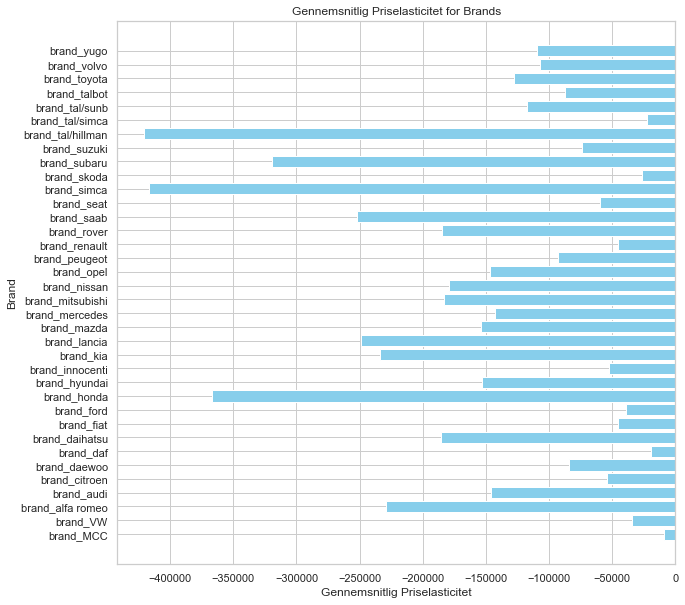

In [36]:
import matplotlib.pyplot as plt

# Navne og værdier til plot
brands = list(brand_elasticities.keys())
elasticities = list(brand_elasticities.values())

# Opret barplot
plt.figure(figsize=(10, 10))
plt.barh(brands, elasticities, color='skyblue')
plt.xlabel('Gennemsnitlig Priselasticitet')
plt.ylabel('Brand')
plt.title('Gennemsnitlig Priselasticitet for Brands')
plt.show()


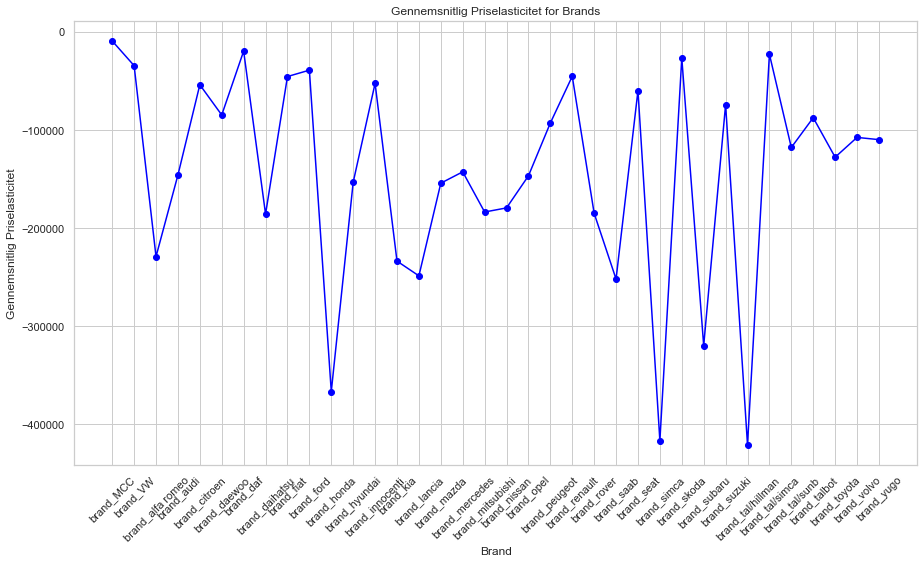

In [37]:
import matplotlib.pyplot as plt

# Forudsætter, at 'brands' er en liste af brand-navne og 'elasticities' er de tilsvarende priselasticitetsværdier.
brands = list(brand_elasticities.keys())  # Brand-navne
elasticities = list(brand_elasticities.values())  # Priselasticitetsværdier

# For at skabe et linjediagram, skal du først sørge for, at dataene er sorteret i den rækkefølge, du vil visualisere dem.
# Her antages det, at 'brands' allerede er i den ønskede rækkefølge. Hvis ikke, skal du sortere dem først.

plt.figure(figsize=(13, 8))
plt.plot(brands, elasticities, marker='o', linestyle='-', color='blue')  # Tilføjer markører til punkterne
plt.xticks(rotation=45)  # Roterer mærkerne på x-aksen for bedre læsbarhed
plt.xlabel('Brand')
plt.ylabel('Gennemsnitlig Priselasticitet')
plt.title('Gennemsnitlig Priselasticitet for Brands')
plt.grid(True)  # Tilføjer et gitter for bedre læsbarhed

# Viser plot
plt.tight_layout()  # Justerer layout for at sikre, at alt passer ind
plt.show()


## Krydspriselasticitet

In [38]:
def calculate_cross_price_elasticity(p_ik, x_ik, beta):
    """
    Beregner krydspriselasticiteten.
    :param p_ik: Markedsandelen for produkt k.
    :param x_ik: Prisen på produkt k.
    :param beta: Den relevante prisparameter.
    :return: Krydspriselasticiteten.
    """
    cross_price_elasticity = -p_ik * x_ik * beta
    return cross_price_elasticity

# Antager at beta_z er den generelle priselasticitetskoefficient
beta_z = -0.9308

# Eksempel på anvendelse
#p_ik = 0.15  # Markedsandelen for produkt k
#x_ik = 10  # Prisen på produkt k

alfa_33_belgium = selected_brands[(selected_brands['model'] == 'alfa 33') & (selected_brands['country'] == 'Belgium')]
alfa_75_belgium = selected_brands[(selected_brands['model'] == 'alfa 75') & (selected_brands['country'] == 'Belgium')]

x_ik = cars[cars['model'] == 'alfa 33']['princ'].mean()  # Gennemsnitlig pris for Alfa 33
p_ik = cars[cars['model'] == 'alfa 75']['s'].mean()  # Gennemsnitlig markedsandel for Alfa 75


# Beregn krydspriselasticiteten mellem Alfa 33 og Alfa 75
cross_price_elasticity = -p_ik * x_ik * beta_z

print(f"Krydspriselasticiteten mellem Alfa 33 og Alfa 75 i Belgien er: {cross_price_elasticity:.4f}")



Krydspriselasticiteten mellem Alfa 33 og Alfa 75 i Belgien er: nan


In [39]:
# Antager at beta_z er den generelle priselasticitetskoefficient
beta_z = -0.9308

# Filtrer data for Alfa 33 og Alfa 75 i Belgien
alfa_33_belgium = selected_brands[(selected_brands['model'] == 'alfa 33') & (selected_brands['country'] == 'Belgium')]
alfa_75_belgium = selected_brands[(selected_brands['model'] == 'alfa 75') & (selected_brands['country'] == 'Belgium')]

# Tjek for at sikre, at der er data tilgængelig
if not alfa_33_belgium.empty and not alfa_75_belgium.empty:
    # Beregn gennemsnitlig pris for Alfa 33 og gennemsnitlig markedsandel for Alfa 75, specifikt for Belgien
    x_ik = alfa_33_belgium['princ'].mean()  # Gennemsnitlig pris for Alfa 33 i Belgien
    p_ik = alfa_75_belgium['s'].mean()  # Gennemsnitlig markedsandel for Alfa 75 i Belgien

    # Beregn krydspriselasticiteten mellem Alfa 33 og Alfa 75
    cross_price_elasticity = calculate_cross_price_elasticity(p_ik, x_ik, beta_z)
    
    print(f"Krydspriselasticiteten mellem Alfa 33 og Alfa 75 i Belgien er: {cross_price_elasticity:.4f}")
else:
    print("Ingen data tilgængelige for Alfa 33 eller Alfa 75 i Belgien.")


Ingen data tilgængelige for Alfa 33 eller Alfa 75 i Belgien.


In [40]:
alfa_33_belgium = cars[(cars['model'] == 'alfa 33') & (cars['brand_alfa romeo'] == 1) & (cars['country'] == 'Belgium')]
alfa_75_belgium = cars[(cars['model'] == 'alfa 75') & (cars['brand_alfa romeo'] == 1) & (cars['country'] == 'Belgium')]

x_ik = cars[cars['model'] == 'alfa 33']['princ'].mean()  # Gennemsnitlig pris for Alfa 33
p_ik = cars[cars['model'] == 'alfa 75']['s'].mean()  # Gennemsnitlig markedsandel for Alfa 75

print(x_ik)

nan


In [41]:
# Filtrering af data for Alfa 33 og Alfa 75 fra Alfa Romeo i Belgien
alfa_33_belgium = cars[(cars['model'] == 'Alfa 33') & (cars['brand_alfa romeo'] == 1) & (cars['country'] == 'Belgium')]
alfa_75_belgium = cars[(cars['model'] == 'Alfa 75') & (cars['brand_alfa romeo'] == 1) & (cars['country'] == 'Belgium')]

# alfa 33
p_ik_33 = alfa_33_belgium['s'].mean()  # Markedsandel 
x_ik_33 = alfa_33_belgium['princ'].mean()  # Gennemsnitlig pris

# alfa 75
p_ik_75 = alfa_75_belgium['s'].mean()  # Markedsandel
x_ik_75 = alfa_75_belgium['princ'].mean()  # Gennemsnitlig pris 

In [42]:
# Korrigering af case-sensitivitet ved filtrering
alfa_33_belgium = cars[(cars['model'].str.lower() == 'alfa 33') & (cars['brand_alfa romeo'] == 1) & (cars['country'].str.lower() == 'belgium')]
alfa_75_belgium = cars[(cars['model'].str.lower() == 'alfa 75') & (cars['brand_alfa romeo'] == 1) & (cars['country'].str.lower() == 'belgium')]

# Tjek igen antallet af rækker for Alfa 33 og Alfa 75 i Belgien
print("Antal rækker for Alfa 33 i Belgien:", len(alfa_33_belgium))
print("Antal rækker for Alfa 75 i Belgien:", len(alfa_75_belgium))


Antal rækker for Alfa 33 i Belgien: 0
Antal rækker for Alfa 75 i Belgien: 0


# Compare OLS, IV and Elasticities

- Sammenligne med en hvor prisen er med
- tage OLS hvor log_s på venstre side
- 2SLS ukorrileret med exogene variable - ikke med prisen
- Prisen er korrileret med et instrument som er ukorrileret med fejlledet
- Godt at sammenligne OLS med IV
- Sammenligne med efterspørgselsligning (log_s mod attributes og prices med OLS)
- Se hvordan priskoefficienten ændrer sig 
- Lave en tabel med OLS, IV - kontrollere for fixed effects, forskellen på IV og OLS - Samle det hele i bunden
- Hvad er egenpris og kryds som ekstra række - 

In [43]:
# Create a DataFrame for the OLS results
firststage_results = pd.DataFrame({
    'Coefficient': first_stage.params,
    'Std. Error': first_stage.bse,
    't-value': first_stage.tvalues,
    'p-value': first_stage.pvalues
})

# Create a DataFrame for the IV results
secondstage_results = pd.DataFrame({
    'Coefficient': second_stage.params,
    'Std. Error': second_stage.std_errors,
    #'t-value': second_stage.tvalues, #- Ingen t-værdi for IV eller hvorfor fejl?
    'p-value': second_stage.pvalues
})

# AC:

# Create a DataFrame for the OLS results
firststage_results_ac = pd.DataFrame({
    'Coefficient': first_stage_ac.params,
    'Std. Error': first_stage_ac.bse,
    't-value': first_stage_ac.tvalues,
    'p-value': first_stage_ac.pvalues
})

# Create a DataFrame for the IV results
secondstage_results_ac = pd.DataFrame({
    'Coefficient': second_stage_ac.params,
    'Std. Error': second_stage_ac.std_errors,
    #'t-value': second_stage.tvalues, #- Ingen t-værdi for IV eller hvorfor fejl?
    'p-value': second_stage_ac.pvalues
})


#WE:


# Create a DataFrame for the OLS results
firststage_results_we = pd.DataFrame({
    'Coefficient': first_stage_we.params,
    'Std. Error': first_stage_we.bse,
    't-value': first_stage_we.tvalues,
    'p-value': first_stage_we.pvalues
})

# Create a DataFrame for the IV results
secondstage_results_we = pd.DataFrame({
    'Coefficient': second_stage_we.params,
    'Std. Error': second_stage_we.std_errors,
    #'t-value': second_stage.tvalues, #- Ingen t-værdi for IV eller hvorfor fejl?
    'p-value': second_stage_we.pvalues
})


#LE:

# Create a DataFrame for the OLS results
firststage_results_le = pd.DataFrame({
    'Coefficient': first_stage_le.params,
    'Std. Error': first_stage_le.bse,
    't-value': first_stage_le.tvalues,
    'p-value': first_stage_le.pvalues
})

# Create a DataFrame for the IV results
secondstage_results_le = pd.DataFrame({
    'Coefficient': second_stage_le.params,
    'Std. Error': second_stage_le.std_errors,
    #'t-value': second_stage.tvalues, Ingen t-værdi for IV
    'p-value': second_stage_le.pvalues
})



# OLS-regressionsmodel har kørt med 'princ' og andre attributter
ols_results_with_princ = pd.DataFrame({
    'Coefficient': model.params,
    'Std. Error': model.bse,
    't-value': model.tvalues,
    'p-value': model.pvalues
})#.reset_index().rename(columns={'index': 'Variable'})

In [44]:
# Combine the results into one DataFrame for comparison
comparison_table = pd.DataFrame({
    'OLS Coefficient': firststage_results['Coefficient'],
    'IV Coefficient': secondstage_results['Coefficient'],
    'Diff_IV_OLS Coeff': secondstage_results['Coefficient'] - firststage_results['Coefficient'],
    'OLS Coefficient_ac': firststage_results_ac['Coefficient'],
    'IV Coefficient_ac': secondstage_results_ac['Coefficient'],
    'Diff_IV_OLS Coeff_ac': secondstage_results_ac['Coefficient'] - firststage_results_ac['Coefficient'],
    'OLS Coefficient_we': firststage_results_we['Coefficient'],
    'IV Coefficient_we': secondstage_results_we['Coefficient'],
    'Diff_IV_OLS Coeff_we': secondstage_results_we['Coefficient'] - firststage_results_we['Coefficient'],
    'OLS Coefficient_le': firststage_results_le['Coefficient'],
    'IV Coefficient_le': secondstage_results_le['Coefficient'],
    'Diff_IV_OLS Coeff_we': secondstage_results_we['Coefficient'] - firststage_results_we['Coefficient'],
    
    'OLS Std. Error': firststage_results['Std. Error'],
    'IV Std. Error': secondstage_results['Std. Error'],
    'Diff_IV_OLS Std. Err': secondstage_results['Std. Error'] - firststage_results['Std. Error'],
    'OLS Std. Error_ac': firststage_results_ac['Std. Error'],
    'IV Std. Error_ac': secondstage_results_ac['Std. Error'],
    'OLS Std. Error_we': firststage_results_we['Std. Error'],
    'IV Std. Error_we': secondstage_results_we['Std. Error'],
    'OLS Std. Error_le': firststage_results_le['Std. Error'],
    'IV Std. Error_le': secondstage_results_le['Std. Error'],
    
    'OLS p-value': firststage_results['p-value'],
    'IV p-value': secondstage_results['p-value'],
    'Diff_IV_OLS p-val': secondstage_results['p-value'] - firststage_results['p-value'],
    'OLS p-value_ac': firststage_results_ac['p-value'],
    'IV p-value_ac': secondstage_results_ac['p-value'],
    'OLS p-value_we': firststage_results_we['p-value'],
    'IV p-value_we': secondstage_results_we['p-value'],
    'OLS p-value_le': firststage_results_le['p-value'],
    'IV p-value_le': secondstage_results_le['p-value'],

})

# Givne beregnede værdier for priselasticitet og egenpriselasticitet
price_elasticity_value = -0.7759101993457133  
own_price_elasticity_value = -0.7093          

# Tilføj priselasticitet og egenpriselasticitet 
# Vi bruger `np.nan` til at udfylde kolonner, hvor vi ikke har værdier
comparison_table.loc['Price Elasticity'] = [price_elasticity_value] + [np.nan] * (len(comparison_table.columns) - 1)
comparison_table.loc['Own Price Elasticity'] = [own_price_elasticity_value] + [np.nan] * (len(comparison_table.columns) - 1)

# Remove Diff_IV_OLS calculations for the last two rows (price elasticities)
#comparison_table.loc['Price Elasticity', 'Diff_IV_OLS Coeff'] = np.nan
#comparison_table.loc['Own Price Elasticity', 'Diff_IV_OLS Coeff'] = np.nan

# Remove NaNs for IV columns in the last two rows (price elasticities) since they're not applicable
#comparison_table.loc['Price Elasticity', ['IV Coefficient', 'IV Std. Error', 'IV p-value']] = np.nan
#comparison_table.loc['Own Price Elasticity', ['IV Coefficient', 'IV Std. Error', 'IV p-value']] = np.nan


comparison_table



,OLS Coefficient,IV Coefficient,Diff_IV_OLS Coeff,OLS Coefficient_ac,IV Coefficient_ac,Diff_IV_OLS Coeff_ac,OLS Coefficient_we,IV Coefficient_we,Diff_IV_OLS Coeff_we,OLS Coefficient_le,...,IV Std. Error_le,OLS p-value,IV p-value,Diff_IV_OLS p-val,OLS p-value_ac,IV p-value_ac,OLS p-value_we,IV p-value_we,OLS p-value_le,IV p-value_le
Intercept,-0.8830,-14.5838,-13.7008,-0.8830,-12.2953,-11.4124,-0.8830,53.3348,54.2177,-0.8830,...,0.2410,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ac,0.0143,0.0371,0.0228,0.0072,NaN,NaN,0.0143,-1.0646,-1.0789,0.0143,...,0.0076,0.0000,0.0000,-0.0000,0.0000,NaN,0.0000,0.0000,0.0000,0.0000
hp,0.0063,NaN,NaN,0.0126,-0.0327,-0.0454,0.0126,-0.9715,-0.9841,0.0126,...,0.0058,0.0000,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
le,0.0018,0.0116,0.0098,0.0018,0.0070,0.0053,0.0018,-0.1238,-0.1256,0.0009,...,NaN,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN
princ_fitted,NaN,-3.9034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
princ_fitted_ac,NaN,NaN,NaN,NaN,-1.3117,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN
princ_fitted_le,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000
princ_fitted_we,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0173,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN
w,NaN,NaN,NaN,0.0072,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN
we,0.0000,0.0020,0.0020,0.0000,0.0020,0.0019,0.0000,NaN,NaN,0.0000,...,0.0002,0.5191,0.0000,-0.5191,0.5191,0.0000,0.5191,NaN,0.5191,0.0000


p-værdi: signifikant effekt på den afhængige variabel i modellen (under 0.05)


- Hvilket brands tages der fat i her?
- Skal med ind i tabellen
- Ols, OLS med brand, OLS med ..., IV 1,2,3 (forskellige valg af instrumenter), priscoefficent hele vejen hen, product på y - Kan ikke sammenligne koeffiecienter
- Beta/sigma går ikke, hvad så? - Binary probit => 
- y* = xbeta + epsilon, N(0, siga^2) y = 1/y* (y*>0), P(y=1|x) = fordelingsfunktionen(xbeta/sigma))
- dif P(y=y|lambda) dif sigma x_k = ø(xbeta / sigma) beta_k/sigma => skal vide beta og sigma i forhold til hinanden ikke hver for sig
- /p og /x= normalisere => kun kende beta/sigma
- nederste rækker = Elasticity_own og Elasticity_cross på tværst af estimaterne til at finde, den med negativ tegn (nedadgående demand)
- Argumentere for hvorfor den er endogen
- Kontrollere for omitted variable
- Forskellige markeder/tider osv.
- kolonne for instrumenterne også argumentere for dem - Herfra vælge den bedste - 
- Variation for at finde bedste price respons - kan også bruge det her instruemnt (Ghandi mm.)
- Kommer til sidst til en konklussion: tager et tal
- Kontrafaktiske beregninger for 5 forskellige beregniner, ændre marginale omkostninger ved benzin biler osv.


**Spørgsmål til Bertel**:
- Hvordan opitmerer jeg krydspriselasticiteten?
- Egenpriser for alle brands er meget ekstrem, hvad kan gøres ved dataen?
- Jeg er ret sikker på mit instrument 'z', men hvad med de andre?
- Får ikke de samme egenpriselasticiteter for et brand, som i Verboven paper
    - Der er nok noget galt med DataFrame ift. måden jeg definerer brands
    
    
    *
    
**Spørgsmål til CounterFactual calculations**
- 1) Annual fuel price (evt. i dollars hvis valuta er nødvendig) 
- 2) Baseline Predictions (Numerical Stability)
    - Regne sum for hvert marked og år
- 3) Tænkte om vi skulle kige på beskattelse i stedet for indtrædelse af ny bil på markedet? Her kunne jeg komme ind på Feebate?
    - Evt. komme ind på Feebate (tilbagebetaling for miljøvenlige biler, afgift på miljøskadelige)
        - Påvirker købernes købsvane så de vælger en grønnere bil?
    - Herefter regne den nye pris for biler med Fee-Bate
    - Regne Market Share for FeeBate
- 4) Komme ind på hvad skatten på tankning skal være?
- 5) Counterfactual simulation 
    - Sammenligne priserne før og efter beskatningerne
    - Regne alle salg med nyt market share 
    - CO2 emission
        - Graf for denne emission